# Demo working on SMACS0723 with PIXSED
1. Remove the diffused emission
2. Create masks

In [1]:
import sys
sys.path.append("/Users/shangguan/Softwares/my_module/pixsed")

import numpy as np
from pixsed.photometry_tools import Image, Atlas
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

Could not import regions, which is required for some of the functionalities of this module.


## Remove the diffused emission

In [2]:
# read the Image.
datapath = '../data'
img = Image(f'{datapath}/SMACS0723_F277W.fits', coord_pix=(5000, 5000))

Set DATE-AVG to '2022-06-07T01:43:31.116' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849472 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674587149.004 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


### Analyze the background

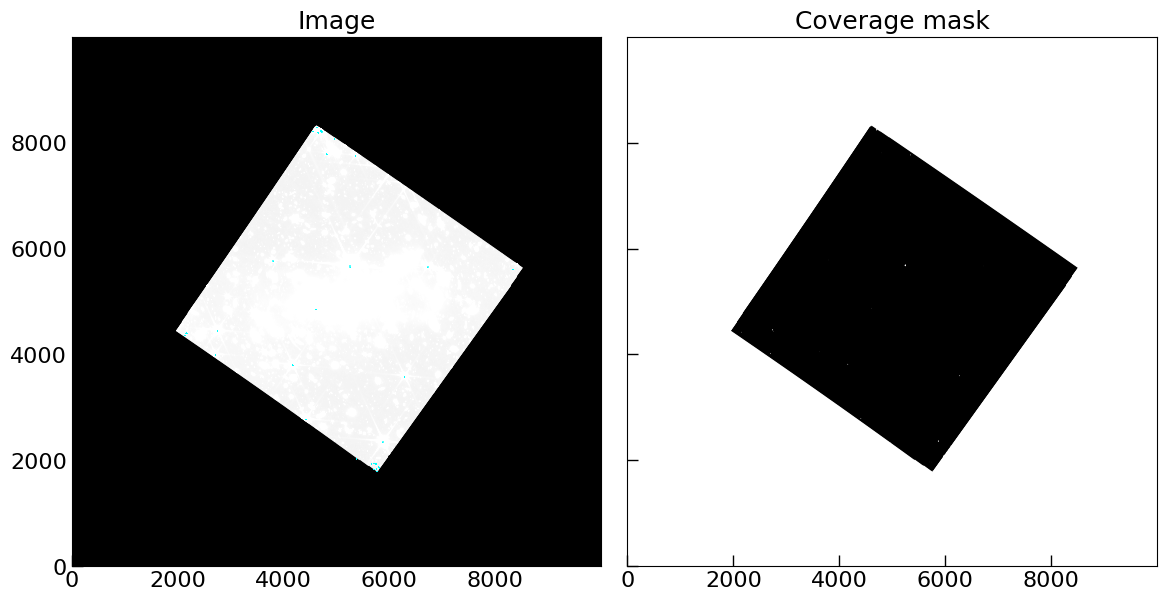

In [3]:
mask_coverage = img.fetch_temp_image('data') == 0
img.set_mask_coverage(mask_coverage, plot=True)

#fig, ax = plt.subplots(1, 1, figsize=(8, 8))
#ax.imshow(mask_coverage, origin='lower', cmap='gray')
#plt.show()

Found 597 masks!


100%|██████████| 597/597 [00:00<00:00, 2920.31it/s]


Found 597 masks!


100%|██████████| 597/597 [00:00<00:00, 2241.19it/s]


CPU times: user 9.71 s, sys: 2.97 s, total: 12.7 s
Wall time: 12.6 s


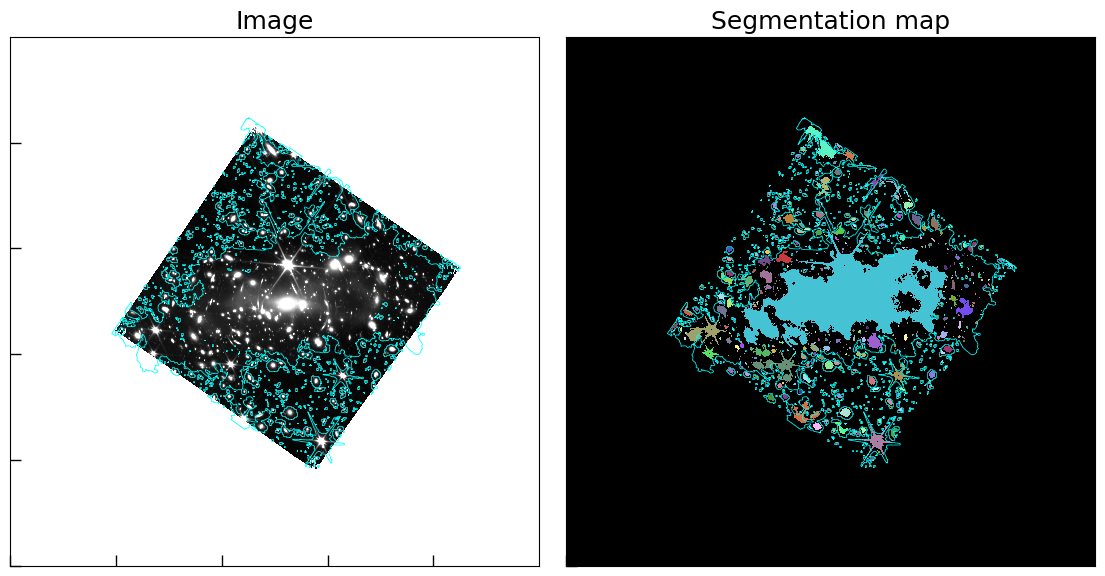

In [4]:
%%time

img.background_properties(mask_type='quick', sigma=3, maxiters=5, f_sample=0.01)
threshold = img._bkg_std
img.gen_mask_background(threshold, kernel_fwhm=10, expand_factor=1.5, plot=True, 
                        norm_kwargs=dict(percent=99, stretch='asinh', asinh_a=0.5),
                        interactive=False)

CPU times: user 23.9 s, sys: 3.36 s, total: 27.3 s
Wall time: 35.5 s


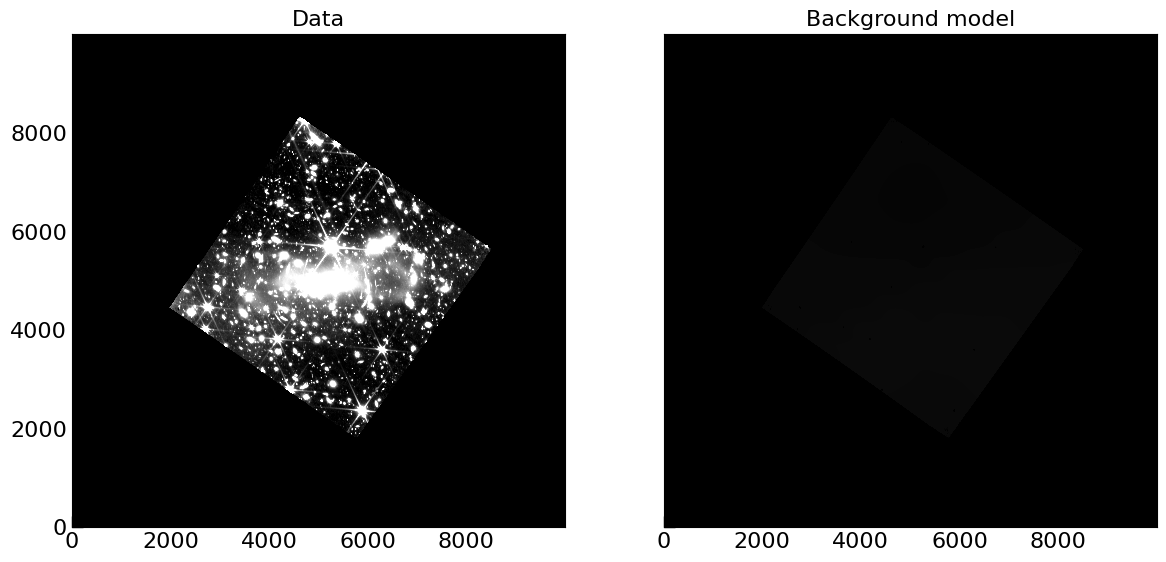

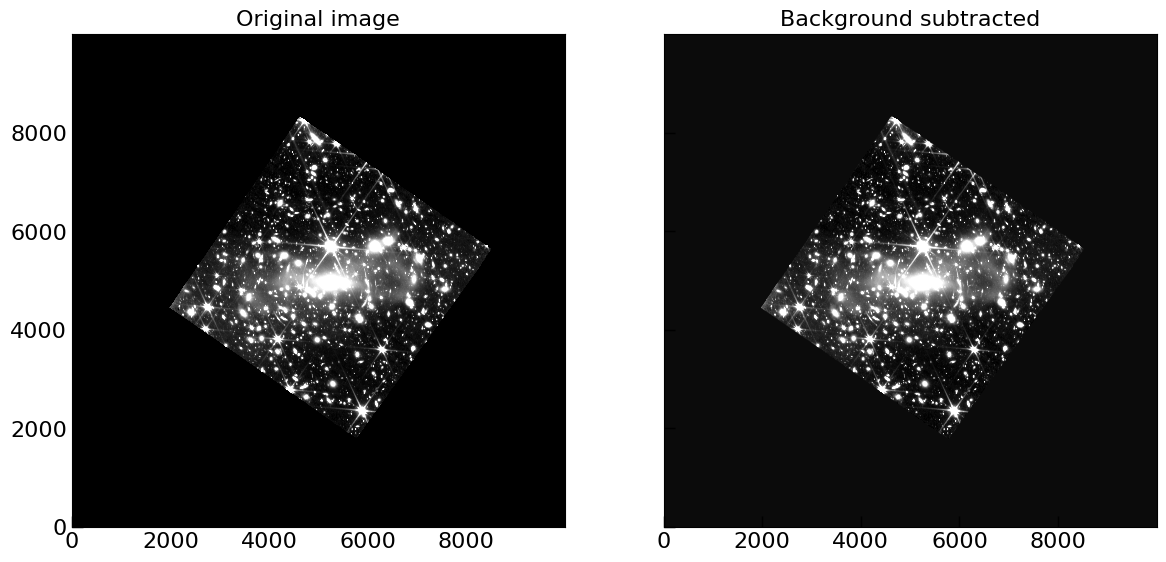

In [5]:
%%time

# It is important not to use a very small box_size!
box_size = img._data.shape[0] // 30
img.gen_model_background(box_size=box_size, filter_size=5, plot=True, norm_kwargs=dict(percent=80, asinh_a=0.1))
img.background_subtract(background_type='model', plot=True, norm_kwargs=dict(percent=90, stretch='asinh', asinh_a=0.5))

### Analyze the sources in the image
* Pinsong: Consider to re-define the mask functions!

CPU times: user 22.1 s, sys: 9.05 s, total: 31.2 s
Wall time: 34.3 s


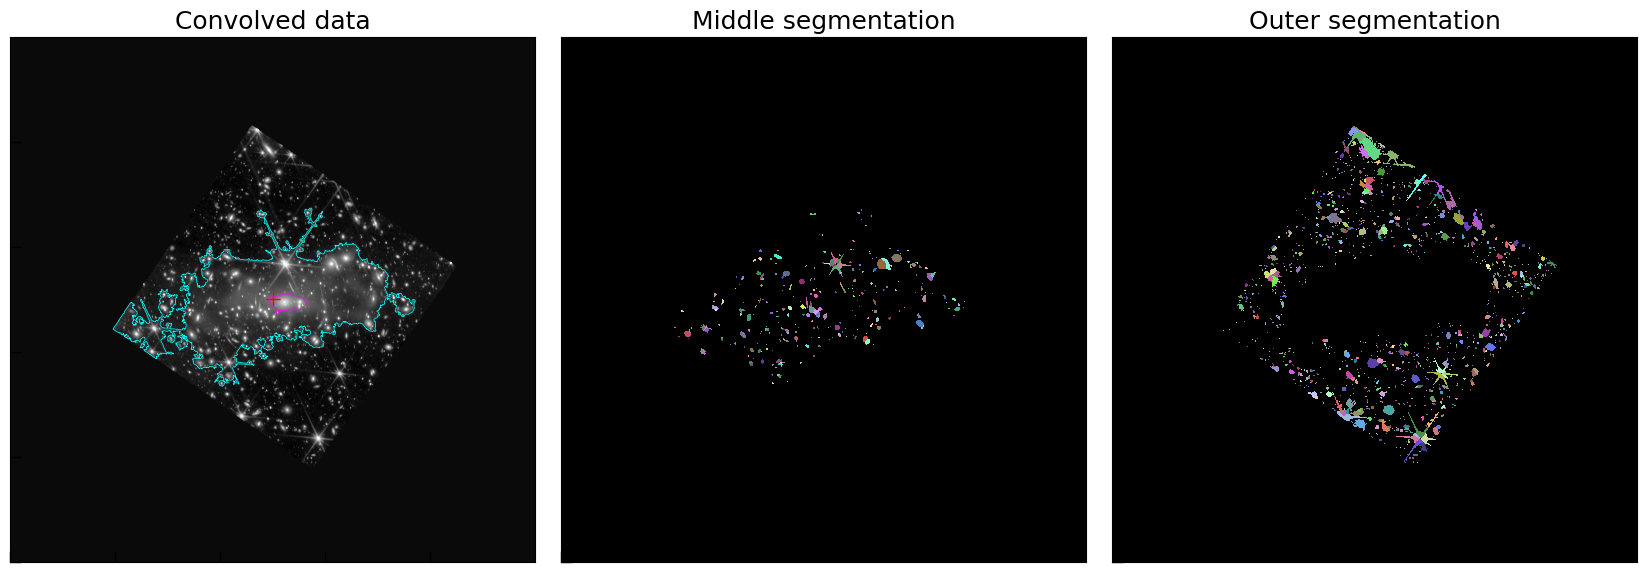

In [7]:
%%time

# Update the background statistics
img.background_properties(mask_type='subbkg', f_sample=0.01)

# Get the target region
threshold = 2 * img._bkg_std
img.gen_target_mask(threshold, kernel_fwhm=10, npixels=5, expand_factor=1, plot=False, 
                    norm_kwargs=dict(percent=99.99, stretch='asinh', asinh_a=0.001),
                    interactive=False)

# Analyze all the sources in the image
threshold_i = 20 * img._bkg_std
threshold_o = 2 * img._bkg_std
img.detect_source_extended(threshold_i=threshold_i, threshold_o=threshold_o, plot=True, interactive=False)

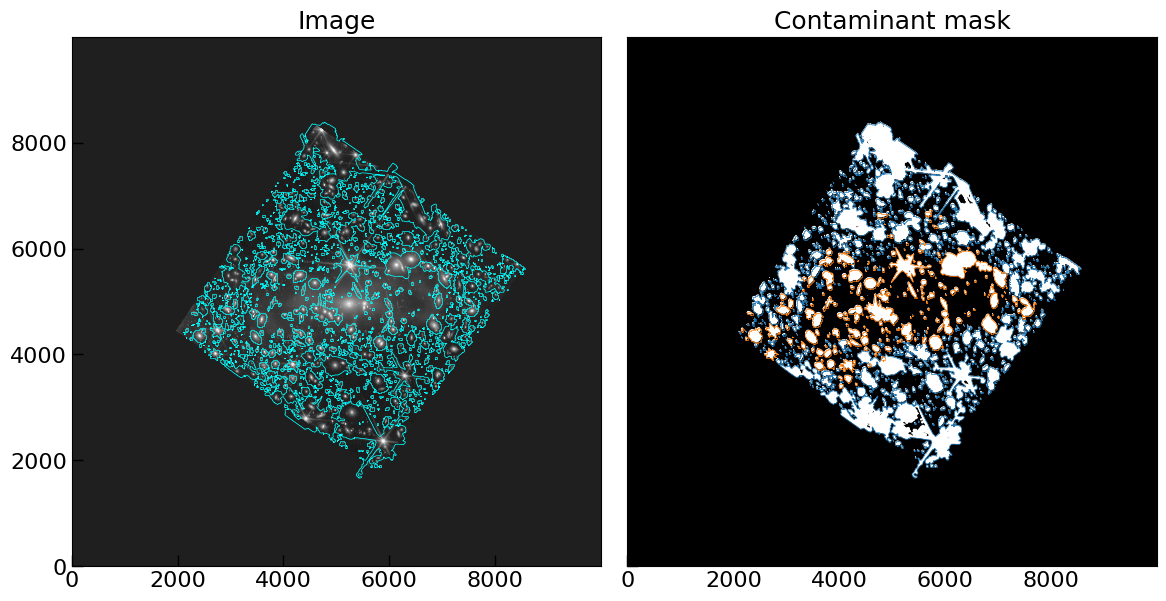

In [8]:
img.gen_mask_contaminant(expand_inner=1, expand_edge=2, expand_outer=2., plot=True, interactive=False)

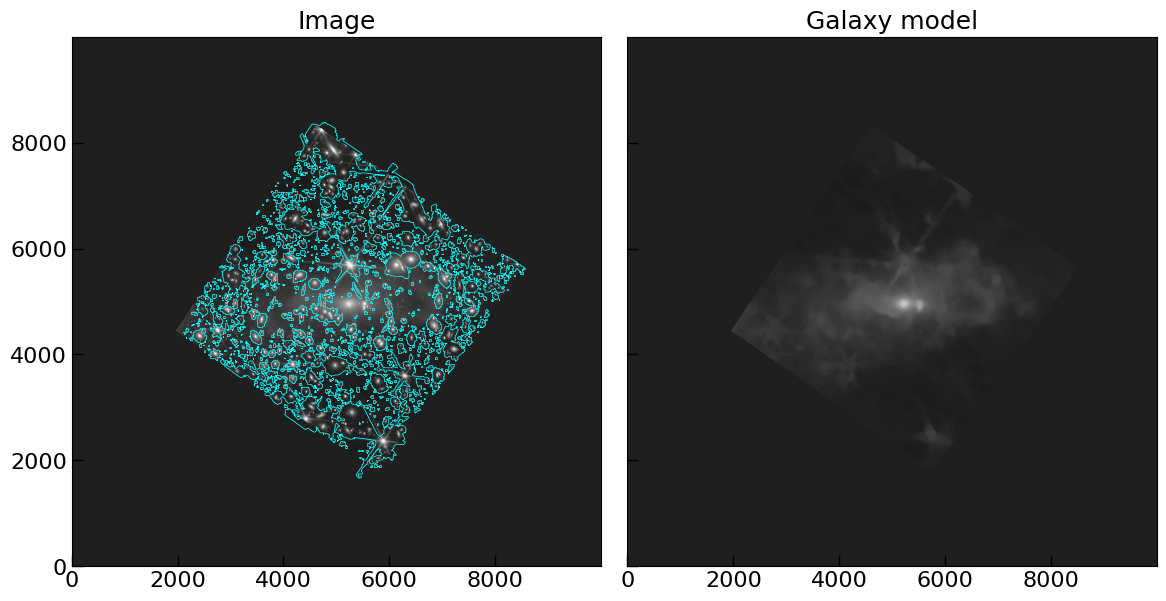

In [9]:
box_size = (30, 30)
img.gen_model_galaxy(box_size=box_size, filter_size=3, plot=True, interactive=False)
plt.show()

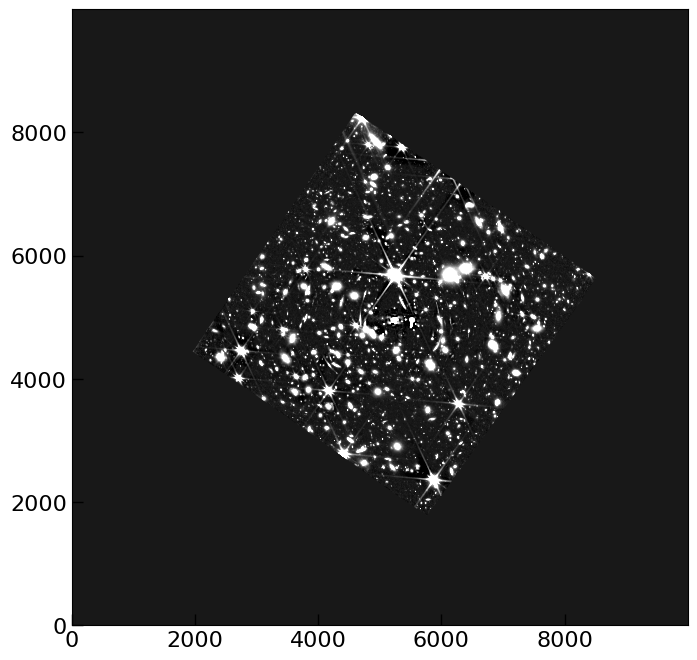

In [10]:
image = img.fetch_temp_image('data_subbkg')
model = img.fetch_temp_image('model_galaxy')
mask_coverage = img.fetch_temp_mask('mask_coverage')

image_clean = image.copy()
image_clean[~mask_coverage] -= model[~mask_coverage]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
norm = simple_norm(image_clean[~mask_coverage], percent=90, stretch='asinh', asinh_a=0.5)
ax.imshow(image_clean, origin='lower', norm=norm, cmap='gray')
plt.show()

from astropy.io import fits

hdul = fits.HDUList([fits.PrimaryHDU(data=image_clean, header=img._header, do_not_scale_image_data=True)])
hdul.writeto('SMACS0723_F277W_clean.fits', overwrite=True)

## Create clean masks

Set DATE-AVG to '2022-06-07T01:43:31.116' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849472 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674587149.004 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


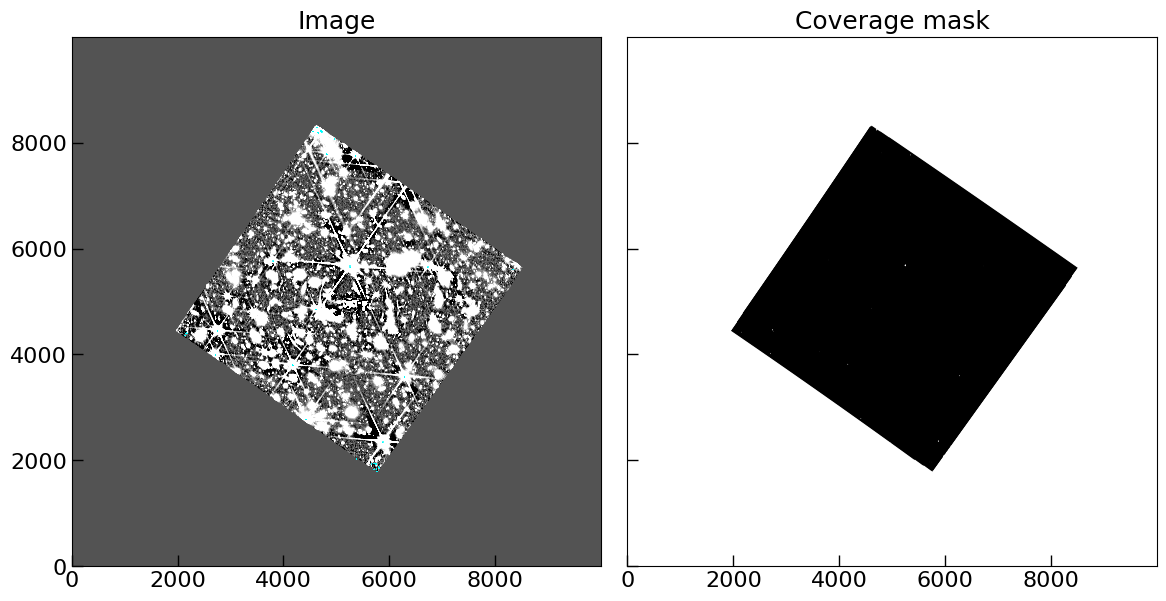

In [11]:
# read the Image.
img = Image(f'SMACS0723_F277W_clean.fits', coord_pix=(5000, 5000))

mask_coverage = img.fetch_temp_image('data') == 0
img.set_mask_coverage(mask_coverage, plot=True)

Found 1003 masks!


100%|██████████| 1003/1003 [00:00<00:00, 2915.70it/s]


Found 1003 masks!


100%|██████████| 1003/1003 [00:00<00:00, 2909.69it/s]


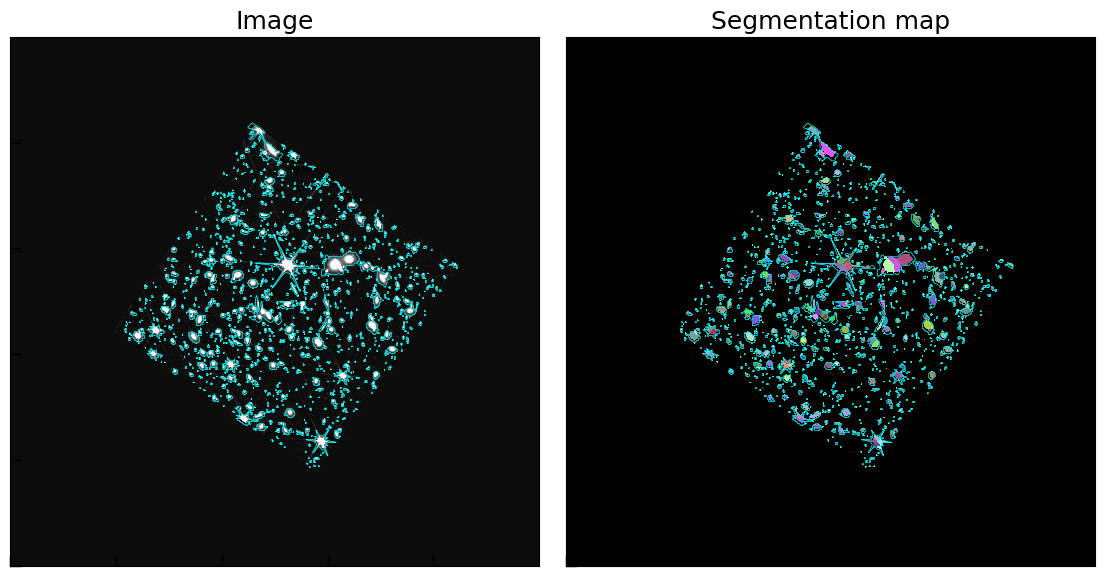

In [22]:
from pixsed.utils import gen_image_mask
img.background_properties(mask_type='quick', sigma=3, maxiters=5, f_sample=0.01)
threshold = 5*img._bkg_std
#img.gen_mask_background(threshold, kernel_fwhm=10, expand_factor=2, plot=True, 
#                        norm_kwargs=dict(percent=90, stretch='asinh', asinh_a=0.5),
#                        interactive=False)
#
#img.background_properties(mask_type='background', sigma=3, maxiters=5, f_sample=0.01)
#threshold = 3*img._bkg_std

# Get deblended masks
data = img.fetch_temp_image('data')
_, segm, cdata = gen_image_mask(data, threshold, kernel_fwhm=10, deblend=True, plot=True, 
                                norm_kwargs=dict(percent=99, stretch='asinh', asinh_a=0.5),
                                interactive=False)